# INFO 2950 Homework 4

For our group time on Friday we will be going through a tutorial on web scraping together. We will not have a separate discussion question.

After the initial demonstration the first graded problem will involve scraping a web page. You should expect to complete the first problem within the session time.

Get started early! Programming involves getting stuck. You need time to be able to ask questions when you're not sure what's wrong or how to fix it. Give yourself enough time that you can ask for help. **Guideline: if you can't figure out how to do something by yourself in 30 minutes or with another person in 15 minutes, ASK FOR HELP.**

You will turn in this notebook without any of the data files. We will not run your code, all cells must be executed and the notebook saved with output included.


## What is web scraping?

Web scraping is the process of creating structured data frames readable by computers from less-structured web pages that are intended to be read by humans.

## Do you need to scrape?

Scraping is difficult, error-prone, and may get you in legal or ethical trouble. Always check if the information you are seeking already exists in a nicer format. Many companies also have APIs or other infrastructure dedicated to serving automated requests.

## Ethics of scraping

Scraping is the aspect of data science most likely to get you into trouble. Legally, there are two main concerns: copyright violation if you are making copies of content that is protected by copyright, and terms-of-service violation. Many sites will also attempt to block scrapers. Acting to avoid these blocks may constitute hacking.

In addition to legal problems, there are ethical problems.

* Respect other people's hard work. Collecting information for a cool website is difficult and takes a long time and careful preparation. Is it fair to take all that work and use it for your purposes?
* Respect other people's businesses. People feed their families by collecting and sharing information, for example through ad revenue. They may be unhappy if they think you are trying to steal their work and prevent them from monetizing it. Websites also sometimes pay for bandwidth and cloud services, and you don't want to take up all their resources for purposes that provide no revenue.
* Respect other people's audiences. Don't [DDOS](https://en.wikipedia.org/wiki/Denial-of-service_attack) a website! Keep requests spaced to about 2/second at most. Web hits don't take a lot of resources, but it's easy to flood a site with requests, locking others out.

## Process

Find a page that contains the info you want. Some older pages are static, but most of what you will see today are views of databases. For example, Amazon has a database of products, Letterboxd has a database of movies, and Netflix has a database of shows. Each page either lists entities in the database or gives information about specific entities.

You would prefer to get access directly to the database, and [in some cases you can](https://s3.amazonaws.com/amazon-reviews-pds/readme.html). But for whatever reason sometimes the web page is all you can get. This process can be difficult because web pages are optimized for people to look at, not for computers to operate on. But it is simpler because in this case a computer has to generate a page *from* a database record and a web browser has to know how to display the elements on the page so that humans can read them. These constraints mean that there are regularities in how specific pieces of information are shown in  HTML, and if you can figure them out, you can reverse the page generation process and get back to something that looks more like a database.

How do you know which pages to get? Often an index or search result page leads to individual pages with more detailed information.

The [`requests`](https://requests.readthedocs.io/en/latest/) library allows you to download files from the web. It is much easier to use than `urllib`. You can use the `requests` library to get information from web pages so that you can save them to files or analyze their data in python.

After using `requests` to access web data, you'll use [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to parse that information, organized in HTML. `BeautifulSoup` makes querying a tree of tags and their attributes much easier than trying to parse HTML from scratch. You'll need to spend some time looking at the target web page and finding the combination of tag names and classes you're interested in, but `BeautifulSoup` can help access that information once you know what you need.


## Installation
As usual, to use these new modules you'll need to first **install `BeautifulSoup` and `requests` to your virtual environment for this class**. This should be a familiar process by now, but hw0 has instructions for installing new modules if you're uncertain. Only once you've completed that process can successfully you run the next cell of code to load in `requests`, `beautifulsoup4`, and other modules. 





In [1]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import time

import seaborn as sns
from matplotlib import pyplot

from sklearn.linear_model import LogisticRegression

## In-session Example: US News college rankings

The TA will show you [this page of college rankings](https://www.usnews.com/best-colleges/rankings/national-universities). The page lists the top national universities according to a variety of university-reported statistics that may or may not be made up (cough COLUMBIA cough).

Our goal is to collect information about colleges. The rankings page contains many links that appear in different ways (eg menus, links in text, etc). We want to find the URL that links to more information about Cornell. How can we figure out how to find this link in the HTML?

We need to put together clues from the structure of the page and the appearance of elements on the page. Appearance is usually determined by the CSS `style` property. Figuring out how to automatically find values from HTML will involve looking at HTML source, ^F searching for values that you want, and figuring out how to identify styles or containing elements. Modern web pages are long and have lots of complicated elements, many of which do not appear as visible content. Starting from the top of the document and reading through is not recommended.

Here are two cached copies of US News pages. These are locally hosted so we don't have hundreds of students hitting US News at the same time. They probably wouldn't notice, but it's more responsible to keep it local.

In [2]:
usnews_url = "https://mimno.infosci.cornell.edu/USNews/best_national.html"
cornell_url = "https://mimno.infosci.cornell.edu/USNews/cornell.html"

The following code does a `GET` request to the web host for the specified filename. HTTP is the protocol used to make web requests. It has a series of "status codes" that tell you the result of request. 200 is success. Others you have probably seen: 404 is "page not found", 403 is "you do not have access". Codes starting with 3-- are often redirects. 500 means there is a bug in the server-side code.

In [3]:
usnews_result = requests.get(usnews_url)
if usnews_result.status_code != 200:
  print("something went wrong:", usnews_result.status_code, usnews_result.reason)

You're never going to get the analysis of a web page right the first time, so it's good to save a local copy of the HTML source so we don't need to hit the server again.

In [4]:
with open("best_national.html", "w") as writer:
  writer.write(usnews_result.text)

Here we're immediately reading the file again, but you could split these into two separate notebooks, one for downloading, one for analysis.

In [5]:
with open("best_national.html", "r") as reader:
  html_source = reader.read()

There are a lot of things that can go wrong when you are accessing web documents. Get in the habit of constantly adding confidence checks to make sure the state of variables is what you expect it to be.

In [6]:
# Make sure this worked
html_source[:30]

'<!DOCTYPE html>\n<!-- saved fro'

Here's where we turn the HTML text from a single long string into a searchable tree of tags. Beautiful Soup can support different ways of parsing including XML, here we'll use an HTML parser.

In [7]:
page = BeautifulSoup(html_source, "html.parser")

Now that we have a structured document we can ask for specific tags. See the Beautiful Soup documentation linked at the top for more details.

In [8]:
page.title

<title>2022-2023 Best National Universities | US News Rankings</title>

We can also find all of the instances of a given tag. We want to find the link that points us to the page where we can find more information about Cornell. What happens if we ask for all the `a` tags?

In [9]:
links = page.find_all("a")
print("there are", len(links), "links on the page")
links[:20]

there are 454 links on the page


[<a class="header__LogoAnchor-sc-1geadoy-1 aBmO" href="https://www.usnews.com/"><img alt="U.S. News and World Report Logo" height="28" src="./2022-2023 Best National Universities _ US News Rankings_files/usn-logo-large.svg" width="110"/></a>,
 <a class="Anchor-byh49a-0 header__RootAnchor-sc-1geadoy-6 bFVXZb dtsmDg" href="https://www.usnews.com/education">Education</a>,
 <a class="header__RootNavAnchor-sc-1geadoy-8 inENeF" data-tracking-campaign="Colleges" data-tracking-id="top_nav" href="https://www.usnews.com/best-colleges">Colleges</a>,
 <a href="https://www.usnews.com/best-colleges/rankings">Rankings and Directories</a>,
 <a class="item__ItemStyled-ji4pk4-0 fIebHX" href="https://www.usnews.com/best-colleges/rankings/national-universities">National Universities</a>,
 <a class="item__ItemStyled-ji4pk4-0 fIebHX" href="https://www.usnews.com/best-colleges/rankings/national-liberal-arts-colleges">National Liberal Arts Colleges</a>,
 <a class="item__ItemStyled-ji4pk4-0 fIebHX" href="https

Whoa, that's too much! Most of these links seem to be navigation links in header menus.

Let's be more specific. Viewing the source, we can search for an interesting string (like "Cornell") and look at the HTML around it.

It seems to be oriented around "cards" for each college.

Inspecting the HTML we find a `div` associated with Cornell with a number of class styles. The most promising one says `detail-card-colleges`. Here's how to find all of the divs with this style.

In [10]:
college_cards = page.find_all("div", {"class": "detail-card-colleges"})
print(len(college_cards))
print(college_cards[16])
print(college_cards[16]["name"])

40
<div class="Box-w0dun1-0 DetailCardColleges__CardContainer-cecerc-0 kueIOo cZokCp detail-card-colleges detail-card-colleges" id="2711" name="Cornell University" spacing="4"><a class="Anchor-byh49a-0 PlBer DetailCardColleges__ImageContainer-cecerc-2 ThuBx" href="https://www.usnews.com/best-colleges/cornell-university-2711#photo-strip"><picture class="Image__Picture-sc-412cjc-0"><source data-srcset="https://www.usnews.com/dims4/USNEWS/375ba3e/17177859217/thumbnail/420x420/quality/85/?url=https%3A%2F%2Fmedia.beam.usnews.com%2F59%2F0dd395ffda36a08c792a2b32303c7b%2Fcollege-photo_73.jpg" media="(min-width: 1024px)" srcset="https://www.usnews.com/dims4/USNEWS/375ba3e/17177859217/thumbnail/420x420/quality/85/?url=https%3A%2F%2Fmedia.beam.usnews.com%2F59%2F0dd395ffda36a08c792a2b32303c7b%2Fcollege-photo_73.jpg"/><source data-srcset="https://www.usnews.com/dims4/USNEWS/3ba42b1/17177859217/thumbnail/336x336/quality/85/?url=https%3A%2F%2Fmedia.beam.usnews.com%2F59%2F0dd395ffda36a08c792a2b32303c7

A common pattern for scraping is that you have a single page that lists links to other pages. Let's find the link to the page with more information about Cornell.

Previously we have been searching the entire DOM tree, but we can also start with a specific element. The number of links just within the Cornell card `div` is more manageable.

The class `card-name` seems promising! 

In [11]:
cornell = college_cards[16]

cornell.find_all("a")

[<a class="Anchor-byh49a-0 PlBer DetailCardColleges__ImageContainer-cecerc-2 ThuBx" href="https://www.usnews.com/best-colleges/cornell-university-2711#photo-strip"><picture class="Image__Picture-sc-412cjc-0"><source data-srcset="https://www.usnews.com/dims4/USNEWS/375ba3e/17177859217/thumbnail/420x420/quality/85/?url=https%3A%2F%2Fmedia.beam.usnews.com%2F59%2F0dd395ffda36a08c792a2b32303c7b%2Fcollege-photo_73.jpg" media="(min-width: 1024px)" srcset="https://www.usnews.com/dims4/USNEWS/375ba3e/17177859217/thumbnail/420x420/quality/85/?url=https%3A%2F%2Fmedia.beam.usnews.com%2F59%2F0dd395ffda36a08c792a2b32303c7b%2Fcollege-photo_73.jpg"/><source data-srcset="https://www.usnews.com/dims4/USNEWS/3ba42b1/17177859217/thumbnail/336x336/quality/85/?url=https%3A%2F%2Fmedia.beam.usnews.com%2F59%2F0dd395ffda36a08c792a2b32303c7b%2Fcollege-photo_73.jpg" media="(min-width: 640px)" srcset="https://www.usnews.com/dims4/USNEWS/3ba42b1/17177859217/thumbnail/336x336/quality/85/?url=https%3A%2F%2Fmedia.beam

Once we find a tag, we can also access attributes of the tag, like the URL target of a link or the text contained within the tag.

In [12]:
for college in college_cards:
  title_link = college.find("a", {"class": "card-name"})
  print(title_link.text, title_link["href"])

Princeton University https://www.usnews.com/best-colleges/princeton-university-2627
Massachusetts Institute of Technology https://www.usnews.com/best-colleges/massachusetts-institute-of-technology-2178
Harvard University https://www.usnews.com/best-colleges/harvard-university-2155
Stanford University https://www.usnews.com/best-colleges/stanford-university-1305
Yale University https://www.usnews.com/best-colleges/yale-university-1426
University of Chicago https://www.usnews.com/best-colleges/university-of-chicago-1774
Johns Hopkins University https://www.usnews.com/best-colleges/jhu-2077
University of Pennsylvania https://www.usnews.com/best-colleges/university-of-pennsylvania-3378
California Institute of Technology https://www.usnews.com/best-colleges/california-institute-of-technology-1131
Duke University https://www.usnews.com/best-colleges/duke-university-2920
Northwestern University https://www.usnews.com/best-colleges/northwestern-university-1739
Dartmouth College https://www.usn


With these links, we could repeat the process and go scrape each university's page. *Please don't do that*.

## Problem 1 (15 points)


The variable `cornell_url` above links to a cached copy of the [Cornell page](https://www.usnews.com/best-colleges/cornell-university-2711). Take some time to inspect the HTML of the page, and then load it, create a Beautiful Soup object, and find some information about Cornell.

Notice the table of data **General Information** with information about Cornell's founding, setting, and academic year. Use `BeautifulSoup` and `requests` to scrape this data and format it as a data frame with one column for the categories of information (e.g., "School Type") and another for the Cornell-specific value (e.g., "Private, Coed"). 

Print out this data frame. 

**Hint: class names are not always meaningful strings like `card-name`.** You'll also notice that bottom right value (the website link). Is different from the other values. You'll need to use a slightly different tag class/name to get this tag. You should save the website's URL (not the word "Website"). 



In [13]:
# Code goes here

# load cornell_url (from office hours)
cornell_page = requests.get(cornell_url)
cornell_html = cornell_page.text
cornell_html[:30] 
#create beautiful soup object 

page = BeautifulSoup(cornell_html, "html.parser")
page.title
cornell_links = page.find_all("p", {"class": "Paragraph-sc-1iyax29-0 lbGMQc"})
looping = [looping.text for looping in cornell_links]

link2 = page.find_all("p", {"class": "Paragraph-sc-1iyax29-0 clmBuI"})
looping2 = [looping.text for looping in link2]
looping2.append(page.find("a", {"class": "optly-school-website"})["href"])

cornell_information = {"details": looping, "information": looping2}
cornelldf = pd.DataFrame(cornell_information)

print(cornelldf) 
cornelldf



                 details              information
0            School Type            Private, Coed
1           Year Founded                     1865
2  Religious Affiliation                     None
3      Academic Calendar                 Semester
4                Setting                    Rural
5                  Phone           (607) 255-2000
6         School Website  http://www.cornell.edu/


,details,information
0,School Type,"Private, Coed"
1,Year Founded,1865
2,Religious Affiliation,None
3,Academic Calendar,Semester
4,Setting,Rural
5,Phone,(607) 255-2000
6,School Website,http://www.cornell.edu/


## Problem 2 (20 points)

Select a page from the web, extract some information from it/them and convert this information into a data frame. Create a visualization of this data frame.

As a suggestion, you may use the [Wikipedia page for Tompkins County, NY](https://en.wikipedia.org/wiki/Tompkins_County,_New_York).

Keep a log of how you chose the page (if you do not use the suggested page), what you had to do to extract information from it, and any challenges you faced and how you overcame them. Mention any people or web pages that you consulted or benefitted from.

**Keep your log notes here.**

I'm going to try do scrape from the tompkins county wikipedia page. 

I used this function to just get miles squared: 
https://stackoverflow.com/questions/8865878/skipping-every-other-element-after-the-first

    area in square miles  population
0                   6.07       32108
1                   6.00        7245
2                   1.77        4114
3                   4.63        3648
4                   1.80        3175
5                   1.50        2701
6                   3.60        2231
7                   1.74        2145
8                   1.77        1887
9                   1.39        1714
10                  0.30        1168
11                  2.80        1078
12                  0.71         767
13                  1.20         725
14                  3.60         516
15                  3.46         506
16                  1.09         498
17                  0.23         378
18                  0.24         261
19                  1.36         211
20                  0.26         208
AxesSubplot(0.125,0.125;0.775x0.755)


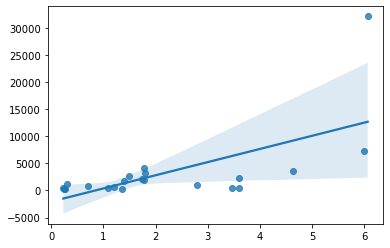

In [14]:
# Code goes here

tompkins_url = "https://en.wikipedia.org/wiki/Tompkins_County,_New_York"
tpage = requests.get(tompkins_url)
thtml = tpage.text
page = BeautifulSoup(thtml, "html.parser")

page.title

#tcategories = ''

tcoordinates = page.find_all("span", {"class": "latitude"})
looping = [looping.text for looping in tcoordinates]
x = [x.text for x in tcoordinates]
#looping.drop([0]) 
# print((looping)) 
# print(len(looping)) 

tpop= page.find_all("td", {"align": "right"})
looping2 = [looping2.text for looping2 in tpop]
y = [y.text for y in tpop]

loop2=[]
# print((looping2)) 

for x in looping2: 
    x = int(x.replace(',', ''))
    loop2.append(x) 

def altElement(a):
    return a[::2]

tarea= page.find_all("td", {"style" : "text-align:right;"}) 

tarea2 = (altElement(tarea)) 
looping3 = [looping3.text for looping3 in tarea2]
loop3=[]

for x in looping3 : 
    x=x[:-1]
    x=float(x) 
    loop3.append(x) 

# print((looping3)) 

# print((looping3)) 

# print(len(looping3)) 

# <td style="text-align:right;" data-sort-value="7006466197859860480">1.8
# </td>


data = {"area in square miles":loop3, "population": loop2 }
datadf = pd.DataFrame(data)
print(datadf) 

#print (looping)

#make a graph


print(sns.regplot(data=datadf, x=loop3, y=loop2) ) 





## Problem 3 (12 points)

In class we mentioned that there are four combinations of logs for inputs and outputs (assume that $\log(x) = \ln(x)$):

1. $y_i = \alpha + \beta x_i + \epsilon_i$
1. $y_i = \alpha + \beta \log(x_i) + \epsilon_i$
1. $\log(y_i) = \alpha + \beta x_i + \epsilon_i$ or equivalently $y_i = e^{\alpha + \beta x_i + \epsilon_i}$
1. $\log(y_i) = \alpha + \beta \log(x_i) + \epsilon_i$ or equivalently $y_i = e^{\alpha + \beta \log(x_i) + \epsilon_i}$

Match these equations to the following statements. Remember that $e^{λ + μ} = e^\lambda e^\mu$. Explain each answer.

*  if you multiply $x$ by $e\ (≈ 2.7)$, we expect $y$ to change by $\beta$
* if you increase $x$ by 1, we expect $y$ to change by a factor of $e^\beta$
* if you increase $x$ by 1, we expect $y$ to change by $\beta$
* if you multiply $x$ by $e\ (≈ 2.7)$, we expect $y$ to change by a factor of $e^\beta$

**Match each equation with its description here.**

1. (if you increase 𝑥 by 1, we expect 𝑦 to change by 𝛽 )- linear 


2. if you multiply 𝑥 by 𝑒 (≈2.7), we expect 𝑦 to change by 𝛽 -  because x is logged 


3. if you increase 𝑥 by 1, we expect 𝑦 to change by a factor of 𝑒^𝛽; because y is regular, x is an exponent of e 


4. if you multiply 𝑥 by 𝑒 (≈2.7), we expect 𝑦 to change by a factor of 𝑒^𝛽 because both sides of equation have log 

**Describe whether the statements are the same or different from the interpretations given in Lecture 7, and explain why or why not.**

the most obvious difference is that this talks about a change in the equation and beta in terms of e~2.7 -- here it seems to be more parameter based and in lecture, lecture notes phrase it in terms of percentage changes. To me the lecture notes seem more digestible than how it is phrased here, in terms of changing "by a factor". 

## Problem 4 (12 points)

Match the following scenarios to one of the four equations in Problem 3, which may be used multiple times or not at all. Explain your answers, including any aspects of the selected model that would not fit if applicable, such as ranges of inputs where a regression equation would or would not be appropriate.

| Input | Output |
| --- | --- |
| Years from 1900-2020 | Population of [Las Vegas, NV](https://en.wikipedia.org/wiki/Las_Vegas) |
| Annual income | Reported happiness |
| Years from 1980-2000 | [S&P 500 index](https://en.wikipedia.org/wiki/S%26P_500)   |
| Days from Aug 25, 2022 to Sept 19, 2022 | [S&P 500 index (live)](https://www.google.com/search?q=s%26p+500) |
| Days after Feb 1, 2020 | Global COVID cases |
| The [rank of an English word](https://en.wikipedia.org/wiki/Zipf%27s_law) (1st most common, 2nd most common, ...) | The frequency of that word in a collection of documents (eg "the" occurs 1.5M times).<br> **Hint: usually about half of the words in a collection appear once** | 


**Match scenarios to equations here**
1) Years from 1900-2020 	Population of Las Vegas, NV: looks to be exponential and positive beta: 𝑦𝑖=𝑒^(𝛼+𝛽𝑥𝑖+𝜖𝑖) : (equation 3) from: https://www.macrotrends.net/cities/23043/las-vegas/population and https://geochange.er.usgs.gov/sw/changes/anthropogenic/population/las_vegas/ .


2) Annual income 	Reported happiness: money is important if your baseline is no income but income becomes negligible after a certain point and more money wont make you happier: 𝑦𝑖=𝛼+𝛽log(𝑥𝑖)+𝜖𝑖: (equation2, and positive beta) 


3) 1980-2000 S&P 500: looks to be exponential: 𝑦𝑖=𝑒^(𝛼+𝛽𝑥𝑖+𝜖𝑖) : (equation 3 and positive beta) 

4) Days from Aug 25, 2022 to Sept 19, 2022 	S&P 500 index (live): seems linear (negative beta): 𝑦𝑖=𝛼+𝛽𝑥𝑖+𝜖𝑖 (Equation 1 ) 



5) Days after Feb 1, 2020 	Global COVID cases: seems exponential: 𝑦𝑖=𝑒^(𝛼+𝛽𝑥𝑖+𝜖𝑖) (equation 3 and a positive beta since modelling positive exponential growth)   

6) The rank of an English word and The frequency of that word in a collection of documents: 
 𝑦𝑖=𝑒^(𝛼+𝛽log(𝑥𝑖)+𝜖𝑖) -- decreasing nature can be modeled using this equation using a negative beta (equation 4) 




## Problem 5 (12 points)

Each of the following plots was generated from one of the four equations in Problem 3. Each equation was used once.

For each equation from the previous problem, specify which of the four plots is most consistent with the equation. State whether $\beta$ is positive or negative. Explain your answers.

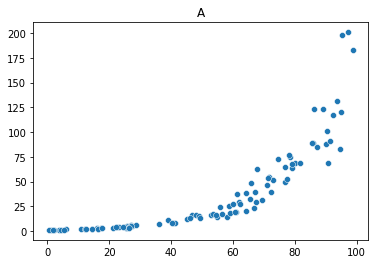
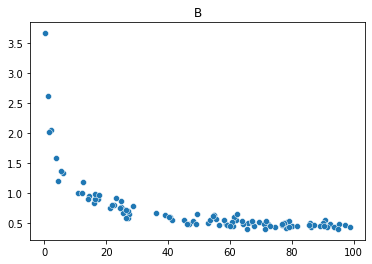


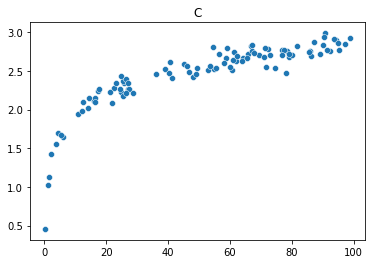

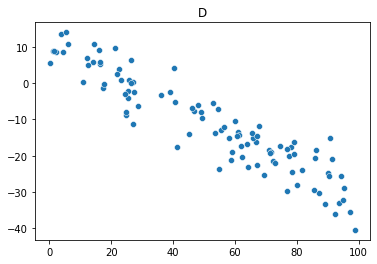




**Match the four equations to the four plots here**

  A equation 3: beta is positive and outputs exponentially increase 
 B equation 4: beta is negative and outputs exponentially decrease and approach 0 . 
 C eqaution 2: beta is positive, as the input increases, the rate of increase of the    outputs approaches 0 
 D equation 1: beta is negative, it looks like a negative linear relationship 

## Problem 6 (9 points)

The following question was inspired by [a visualization by Kyle Walker](https://gist.github.com/walkerke/f31b90ffc24908e424c9e08d6fcd5cad). The data is saved from running his R script. It combines data from the US Census Bureau about people working from home and data from the Daily Kos about US election results from 2020.

Each row of the file `wfh_congress.csv` represents a US congressional district. The column `wfh_percent` is the proportion of people reporting that they work from home some amount of the time. The column `biden` is the proportion of votes in the 2020 US presidential election going to Joe Biden. `party` is a string representing whether the elected representative of the district is a Republican or Democrat.

Load the file and display the first five rows.

Use `seaborn` to create a scatter plot showing one point for each district with Biden % on the $x$-axis and WFH % on the $y$-axis, with the `hue` set to the `party`. (**Hint: it's fine to pass a string value to `hue`**).

Comment on whether you think `party` can be predicted from Biden % and WFH %, and which of those two variables will be more accurate. Explain your answer by describing properties of the scatter plot. 

<AxesSubplot:xlabel='biden', ylabel='wfh_percent'>

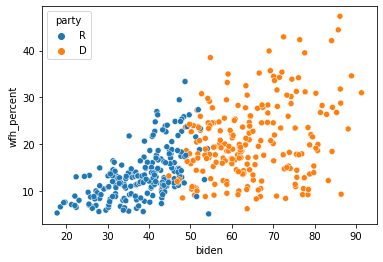

In [15]:
# Code goes here

df= pd.read_csv('wfh_congress.csv')
sns.scatterplot(x=df['biden'], y=df["wfh_percent"], hue=df['party'])


**Your discussion here.**

yes I think that party can be somwhat inferred from wfh percent because all of the highest values of wfh percent are dems whereas the lowest percentage of wfh individuals are republicans, despite overlap between the two. Predicticting party based on who voted for biden and who did not is definitely more straight-forward because when looking at the graph, there seems to be a clear divide between biden voters and dems vs non biden voters and republicans 

## Problem 7 (10 points)

Use `sklearn` to fit a logistic regression model that predicts `party` given `biden`. **Hint: sklearn can interpret string values as binary outputs, you don't need to modify them.** Print the coefficients and intercept of the resulting model.

Use `predict_proba` to calculate the probability that each district will have a value of `party`. Add predicted probability as a new variable `biden_prediction` on the dataframe. **Hint: this function returns a 2D array containing the probability of each output symbol ("R" and "D") for each input. Select the 0th column**.

Create a scatter plot showing `biden` on the $x$-axis, `party` on the $y$-axis, with `hue` from `biden_prediction`.

Repeat this process, replacing `biden` with `wfh_percent`. Display regression parameters, create a new column `wfh_prediction`, and show a scatter plot.

Describe the interpretation of your two models. What happens to the odds of having a Republican representative if each input variable goes up by 1%? Based on the scatter plots, how confident are the two models in their predictions?

[[-0.5617738]]
[27.99464835]
AxesSubplot(0.125,0.125;0.775x0.755)


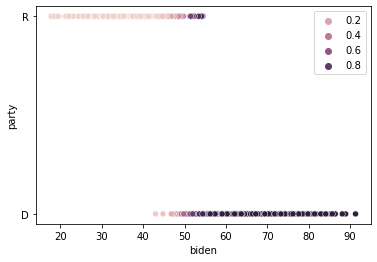

In [16]:
# Code goes here

x = np.array(df['biden']).reshape(-1,1) 
y = np.array(df['party']) 
model=LogisticRegression().fit(x,y)

biden_prediction = model.predict_proba(x)[:,0]

print(model.coef_ ) 
print(model.intercept_ ) 

print(sns.scatterplot(data=df, x="biden", y="party", hue= biden_prediction)) 





[[-0.16720445]]
[2.73113439]


<AxesSubplot:xlabel='wfh_percent', ylabel='party'>

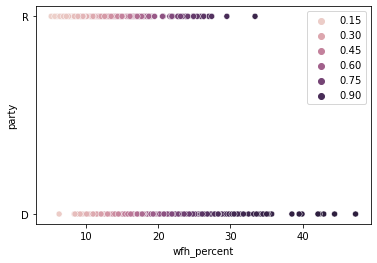

In [17]:

x = np.array(df['wfh_percent']).reshape(-1,1) 
y = np.array(df['party']) 
model=LogisticRegression().fit(x,y)

print(model.coef_ ) 
print(model.intercept_ )

wfh_prediction = model.predict_proba(x)[:,0]


sns.scatterplot(data=df, x="wfh_percent", y="party", hue= wfh_prediction)

**Your discussion here.**
Describe the interpretation of your two models. What happens to the odds of having a Republican representative if each input variable goes up by 1%? Based on the scatter plots, how confident are the two models in their predictions?

from my understanding of the scatterplot, a 1% change in each input variable wouldn't substantially change the outcome. Because of the nature of these models if everything changes by 1%, they would still be in the same relation to each other and you wouldn't notice a significant change. 

Model one seems much more confident in terms of predicting, because it is much more polarised in terms of most registered repiblicans voted for biden with a low probability and most registered dems voted for biden with a higher probability, and these probabilities tended to skew towards a discrete 0 or 1-- insofar as guessing who voted for whom based on party registration and guessing party registration based on who voted for whom is relatively straight forward and easy to predict. 

predicting party registration is somewhat less straighforward but still visually possible-- we can tell that more dems are wfh than there are repubs who wfh and more repubs who do not wfh than there are dems who do not wfh. 

## Problem 8 (10 points)

Train a third logistic regression model with *both* `wfh_percent` and `biden` as inputs. Print the coefficients and intercept.

Describe whether these values are similar or different to the previous two models. Explain why you might have gotten these results.

In [18]:
# Code goes here

# a = np.array(df['biden']).reshape(-1,1) 
# b = np.array(df['wfh_percent']).reshape(-1,1)
# c = df["party"]


# ab_model =LogisticRegression().fit(a+b, c)
# coef = ab_model.coef_
# print(coef) 
# intercept = ab_model.intercept_ 
# print(intercept)

# print("      ")

model2= LogisticRegression().fit(df[['wfh_percent','biden']],df['party'])
print(model2.coef_)
print(model2.intercept_)


[[ 0.03449056 -0.57849804]]
[28.19719259]


**Your discussion here.**


comparing: 

 0.03449056 and -0.16720445 : this is a weaker correlation so I would expect more variation between the two, given the weaker relationship. I would say that the positive correlation coefficient is definitely more correct than the netative coefficient. 
 
and 

-0.57849804 and -0.5617738 : these are more similar and I would expect this because this is for a stronger correlation than wfh% 

and comparing: 

27.99464835 and 28.19719259 : I would expect a really close estimate for the intercept, which is what we get. 